# Assignment-02: Geospatial EDA on US Road Accidents

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import pandas as pd
import numpy as np
DATA_PATH = '/content/drive/MyDrive/Colab Notebooks/RoadSafety_Nov25/data/raw/US_Accidents_March23.csv'


USE_SAMPLE = True
SAMPLE_FRAC = 0.1  # 10% sample

df = pd.read_csv(DATA_PATH)

if USE_SAMPLE:
    df = df.sample(frac=SAMPLE_FRAC, random_state=42).reset_index(drop=True)

df.shape, df.head()

((772839, 46),
           ID   Source  Severity                     Start_Time  \
 0  A-7182628  Source1         1            2020-04-17 09:29:30   
 1  A-5404588  Source1         2  2022-04-21 10:01:00.000000000   
 2   A-156000  Source3         3            2016-08-12 16:45:00   
 3  A-1871277  Source2         3            2019-09-20 15:22:16   
 4  A-2031222  Source2         2            2019-06-03 16:55:43   
 
                         End_Time  Start_Lat   Start_Lng    End_Lat  \
 0            2020-04-17 10:29:30  26.706900  -80.119360  26.706900   
 1  2022-04-21 11:44:08.000000000  38.781024 -121.265820  38.780377   
 2            2016-08-12 17:15:00  33.985249  -84.269348        NaN   
 3            2019-09-20 15:56:00  47.118706 -122.556908        NaN   
 4            2019-06-03 18:12:09  33.451355 -111.890343        NaN   
 
       End_Lng  Distance(mi)  ... Roundabout Station   Stop Traffic_Calming  \
 0  -80.119360         0.000  ...      False   False  False           Fals

In [ ]:
!pip install folium

## Q1. Spatial Distribution and Hotspots

**Question:**  
**Where are the major spatial hotspots of road accidents in the United States, and how do they differ across states and cities?**

### Tasks

1. Map accident locations using latitude and longitude to visualize overall spatial distribution (e.g., point map, heatmap, or coarse grid density map).  
2. Identify and list the top states and top cities by accident count and compare them using plots or summary tables.  
3. Highlight at least two clear hotspot regions and briefly interpret possible reasons (e.g., urbanization, highways, population density) using the spatial patterns observed.


Top 15 states by accident count:
 State
CA    173589
FL     87287
TX     58139
SC     38511
NY     34490
NC     34152
VA     30534
PA     29706
MN     19317
OR     18113
AZ     17148
TN     16995
IL     16908
GA     16837
MI     16460
Name: count, dtype: int64

Top 15 cities by accident count:
 City
Miami          18525
Houston        16937
Los Angeles    15628
Charlotte      14036
Dallas         13146
Orlando        10995
Austin          9715
Raleigh         8622
Nashville       7425
Baton Rouge     7175
Atlanta         6723
Sacramento      6594
San Diego       5559
Phoenix         5423
Minneapolis     5225
Name: count, dtype: int64


/tmp/ipython-input-3234328224.py:21: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_states.values, y=top_states.index, palette='viridis')
/tmp/ipython-input-3234328224.py:26: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_cities.values, y=top_cities.index, palette='magma')


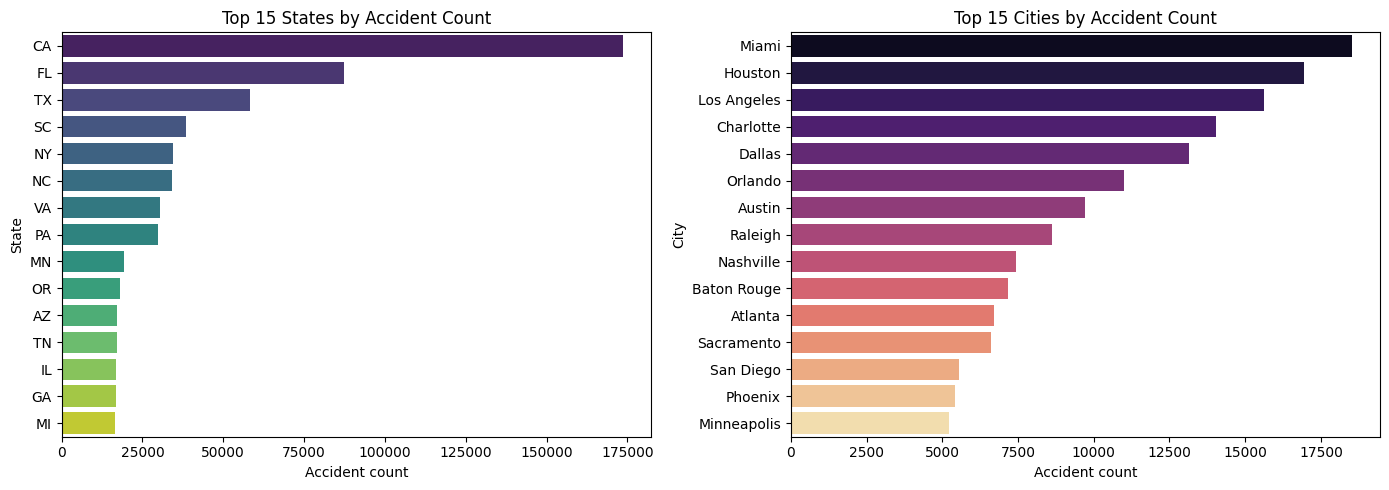

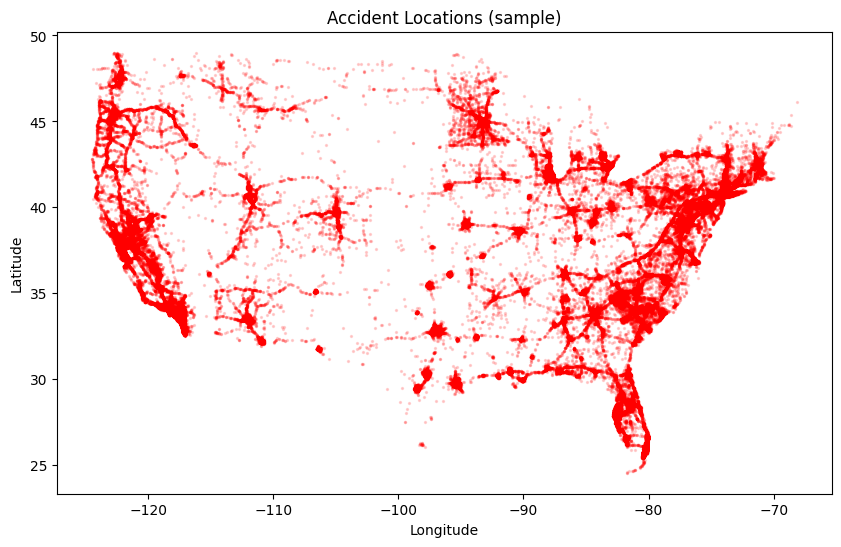

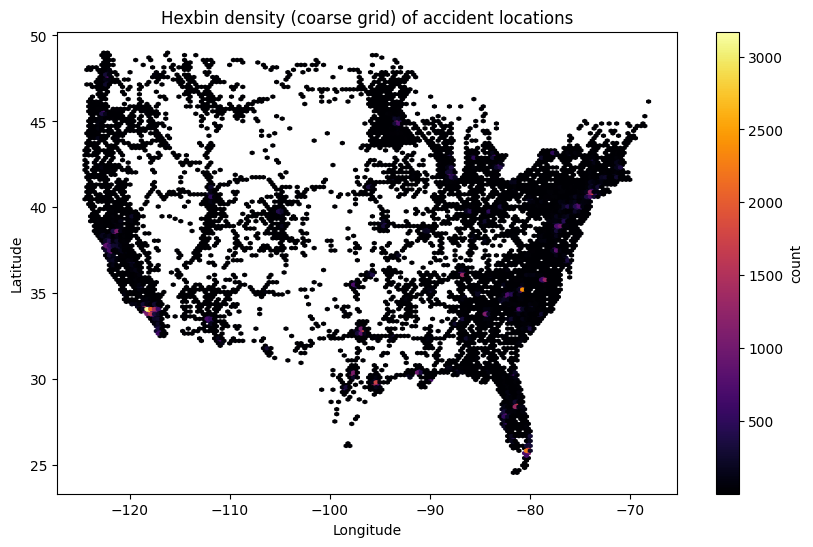

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import folium
from folium.plugins import HeatMap

# lat/lng numeric and drop missing coords
df['Start_Lat'] = pd.to_numeric(df['Start_Lat'], errors='coerce')
df['Start_Lng'] = pd.to_numeric(df['Start_Lng'], errors='coerce')
geo_df = df.dropna(subset=['Start_Lat', 'Start_Lng']).copy()

#1) Top states and cities by accident count
top_states = geo_df['State'].value_counts().head(15)
top_cities = geo_df['City'].value_counts().head(15)

print("Top 15 states by accident count:\n", top_states)
print("\nTop 15 cities by accident count:\n", top_cities)

# Bar plots (states & cities)
plt.figure(figsize=(14,5))
plt.subplot(1,2,1)
sns.barplot(x=top_states.values, y=top_states.index, palette='viridis')
plt.title('Top 15 States by Accident Count')
plt.xlabel('Accident count')

plt.subplot(1,2,2)
sns.barplot(x=top_cities.values, y=top_cities.index, palette='magma')
plt.title('Top 15 Cities by Accident Count')
plt.xlabel('Accident count')
plt.tight_layout()
plt.show()

#2) Spatial distribution: scatter
# Sample for plotting if dataset still large
plot_sample = geo_df.sample(n=min(200000, len(geo_df)), random_state=42)

plt.figure(figsize=(10,6))
plt.scatter(plot_sample['Start_Lng'], plot_sample['Start_Lat'], s=2, alpha=0.15, c='red')
plt.title('Accident Locations (sample)')
plt.xlabel('Longitude'); plt.ylabel('Latitude')
plt.show()

# Hexbin / density (gives coarse hotspots)
plt.figure(figsize=(10,6))
plt.hexbin(plot_sample['Start_Lng'], plot_sample['Start_Lat'], gridsize=150, cmap='inferno', mincnt=1)
plt.colorbar(label='count')
plt.title('Hexbin density (coarse grid) of accident locations')
plt.xlabel('Longitude'); plt.ylabel('Latitude')
plt.show()

#3) Interactive Folium HeatMap of sampled points
# center map at median coords
center_lat = plot_sample['Start_Lat'].median()
center_lng = plot_sample['Start_Lng'].median()

m = folium.Map(location=[center_lat, center_lng], zoom_start=4, tiles='CartoDB positron')

# prepare data
heat_data = plot_sample[['Start_Lat', 'Start_Lng']].values.tolist()

HeatMap(heat_data, radius=8, blur=12, min_opacity=0.2).add_to(m)

# display folium map in notebook
m


## Q2. Spatial–Temporal Patterns within a State

**Question:**  
**How do accident patterns vary by time of day and month within a specific high-accident state (e.g., CA or TX), and are these patterns spatially concentrated?**

### Tasks

1. Choose one state with a high number of accidents and create hourly and monthly distributions of accidents (bar plots).  
2. Overlay or compare these distributions with maps for selected hours (e.g., peak vs off-peak) or seasons (e.g., winter vs summer) to see whether certain locations within the state become more active at specific times.  
3. Describe any spatial–temporal clusters you observe (e.g., urban cores at rush hour, specific corridors in certain months).


Rows for CA: (173589, 48)


/tmp/ipython-input-4047907473.py:21: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x="Hour", data=state_df, palette="viridis")


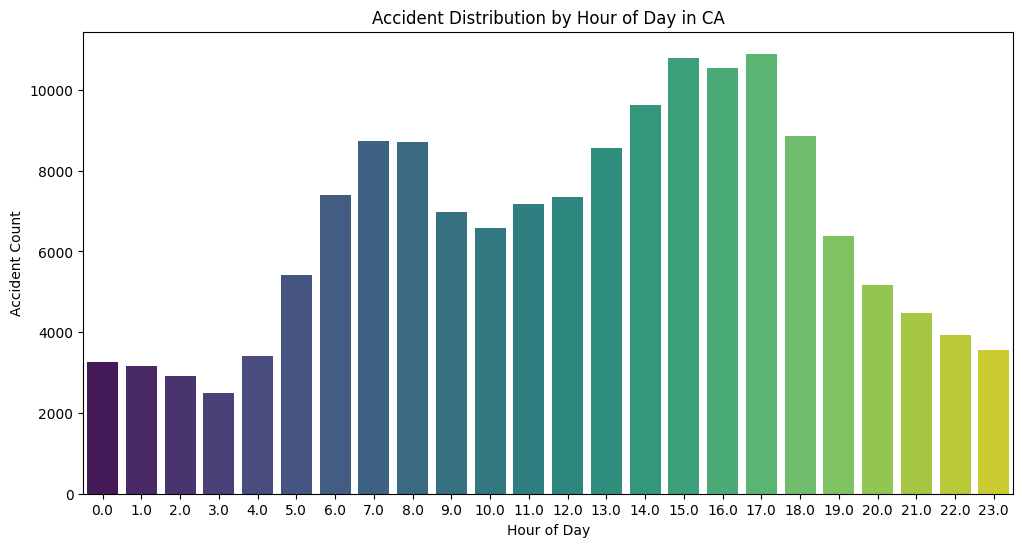

/tmp/ipython-input-4047907473.py:31: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x="Month", data=state_df, palette="magma")


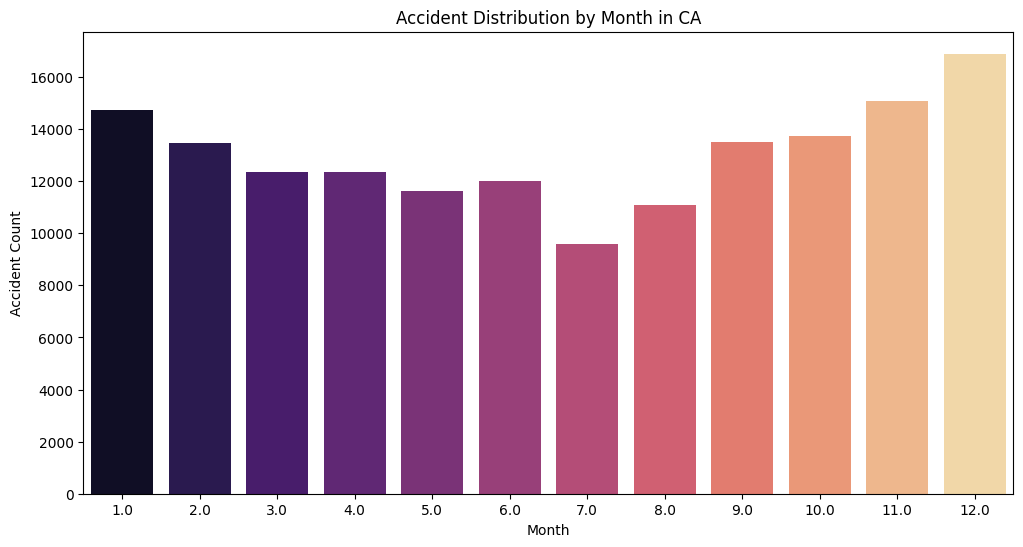

<function matplotlib.pyplot.show(close=None, block=None)>

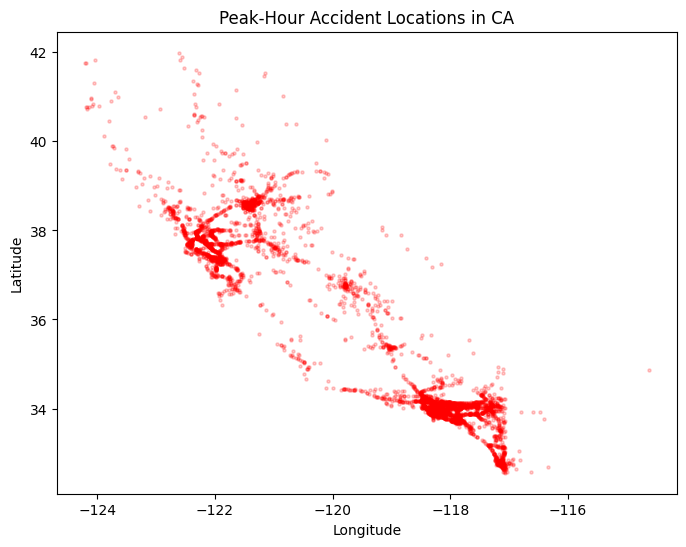

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Convert Start_Time to datetime
df["Start_Time"] = pd.to_datetime(df["Start_Time"], errors="coerce")

# Create hour and month columns
df["Hour"] = df["Start_Time"].dt.hour
df["Month"] = df["Start_Time"].dt.month

# Choose a high-accident state
state = "CA"
state_df = df[df["State"] == state].dropna(subset=["Start_Lat", "Start_Lng"])

print(f"Rows for {state}: {state_df.shape}")


# 1. Hourly Accident Distribution (Bar Plot)

plt.figure(figsize=(12,6))
sns.countplot(x="Hour", data=state_df, palette="viridis")
plt.title(f"Accident Distribution by Hour of Day in {state}")
plt.xlabel("Hour of Day")
plt.ylabel("Accident Count")
plt.show()


# 2. Monthly Accident Distribution (Bar Plot)

plt.figure(figsize=(12,6))
sns.countplot(x="Month", data=state_df, palette="magma")
plt.title(f"Accident Distribution by Month in {state}")
plt.xlabel("Month")
plt.ylabel("Accident Count")
plt.show()


# 3. Spatial Patterns: Peak vs Off-Peak Hours

peak_hours = [7, 8, 9, 16, 17, 18]    # Rush hours
offpeak_hours = [1, 2, 3, 4]         # Low activity hours

# Filter rows
peak_df = state_df[state_df["Hour"].isin(peak_hours)]
offpeak_df = state_df[state_df["Hour"].isin(offpeak_hours)]

# SAFE sampling
peak_df = peak_df.sample(min(5000, len(peak_df)), random_state=42)
offpeak_df = offpeak_df.sample(min(5000, len(offpeak_df)), random_state=42)

# Peak-hour map
plt.figure(figsize=(8,6))
plt.scatter(peak_df["Start_Lng"], peak_df["Start_Lat"], s=5, alpha=0.2, c="red")
plt.title(f"Peak-Hour Accident Locations in {state}")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.show


## Q3. Geospatial Correlates of Severity

**Question:**  
**How does accident severity vary across space, and what geospatial or contextual factors appear associated with high-severity accidents?**

### Tasks

1. Map accidents colored (or otherwise distinguished) by severity level to see how severe accidents are distributed geographically.  
2. Compare severity distributions across a few selected cities or states, or across urban vs non-urban areas, using plots and maps.  
3. Relate severity to at least one additional spatial/context variable (e.g., weather conditions, presence of junctions/crossings, proximity to highways) and discuss any spatial pattern that emerges.


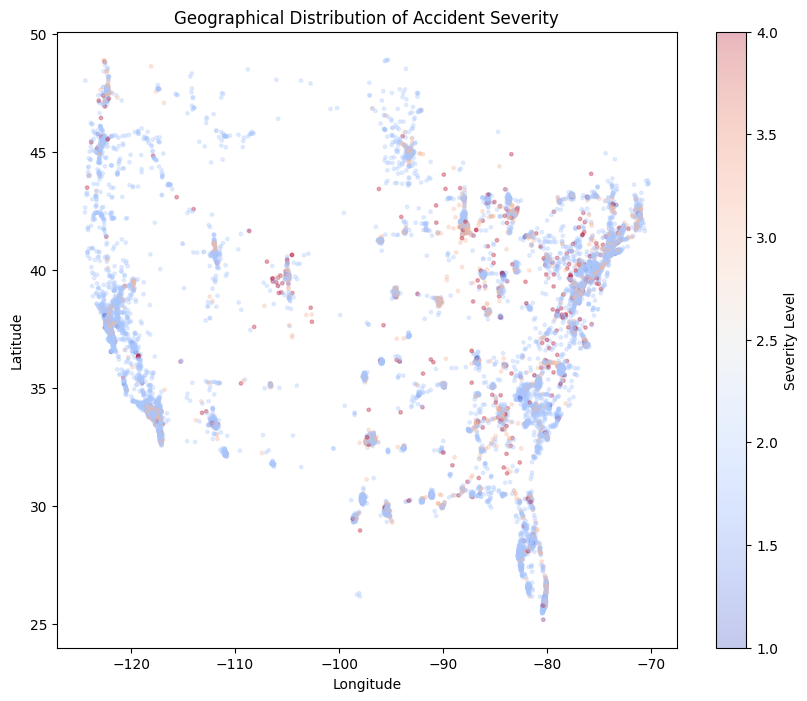

/tmp/ipython-input-2807207609.py:35: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x="State", y="Severity", data=state_df, palette="Set2")


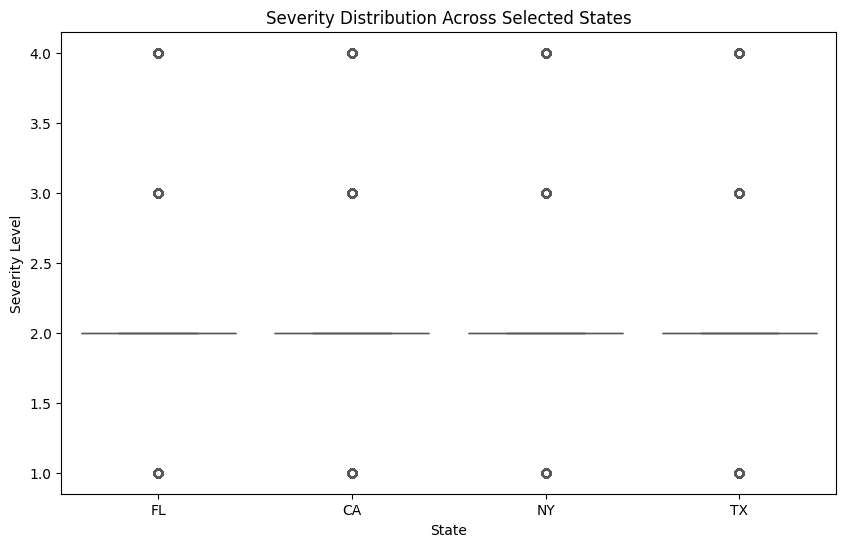

/tmp/ipython-input-2807207609.py:48: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x="Urban", y="Severity", data=df, palette="Set3")


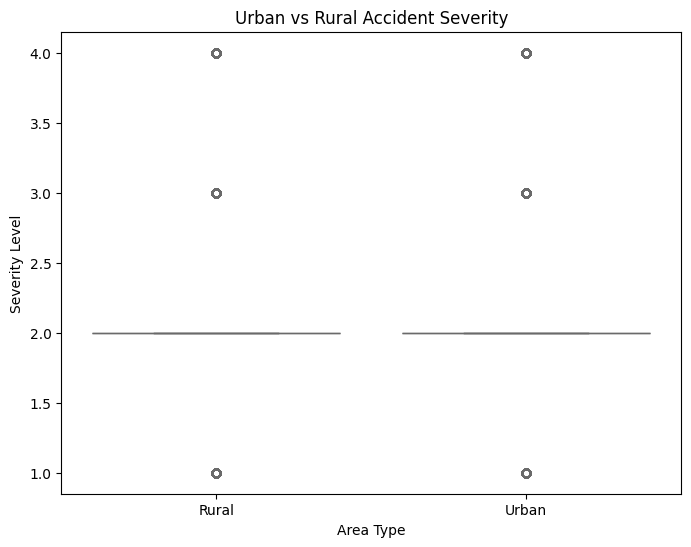

In [ ]:
# Q3. Geospatial Correlates of Severity

import matplotlib.pyplot as plt
import seaborn as sns

# Convert Start_Time to datetime
df["Start_Time"] = pd.to_datetime(df["Start_Time"], errors="coerce")


# 1. Map accidents colored by severity
sev_sample = df.dropna(subset=["Start_Lat", "Start_Lng", "Severity"])
sev_sample = sev_sample.sample(min(15000, len(sev_sample)), random_state=42)

plt.figure(figsize=(10,8))
scatter = plt.scatter(
    sev_sample["Start_Lng"],
    sev_sample["Start_Lat"],
    c=sev_sample["Severity"],
    s=6,
    alpha=0.3,
    cmap="coolwarm"
)
plt.colorbar(scatter, label="Severity Level")
plt.title("Geographical Distribution of Accident Severity")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.show()

# 2. Severity distribution across selected states

selected_states = ["CA", "TX", "FL", "NY"]
state_df = df[df["State"].isin(selected_states)]

plt.figure(figsize=(10,6))
sns.boxplot(x="State", y="Severity", data=state_df, palette="Set2")
plt.title("Severity Distribution Across Selected States")
plt.xlabel("State")
plt.ylabel("Severity Level")
plt.show()



# 3. Urban vs Rural severity comparison
# Assume 'Amenity' near roads = Urban proxy
df["Urban"] = df["Amenity"].apply(lambda x: "Urban" if x == True else "Rural")

plt.figure(figsize=(8,6))
sns.boxplot(x="Urban", y="Severity", data=df, palette="Set3")
plt.title("Urban vs Rural Accident Severity")
plt.xlabel("Area Type")
plt.ylabel("Severity Level")
plt.show()